## Repeated Copy

In this task, a sequence of bit vectors is provided to the model. The input sequence starts with a reserved start vector, then some random binary bit vectors, followed by a reserved count vector, providing the number of intended repetition in a reserved channel. The model is expected to start reproducing the exact input bit vectors for given number of repetitions immediately after observing the count vector.





In [1]:
from util import *
from dnc_lstm import DNC
from dnc_ff import DNCFF
from autograd import grad
from autograd.misc.optimizers import rmsprop, adam

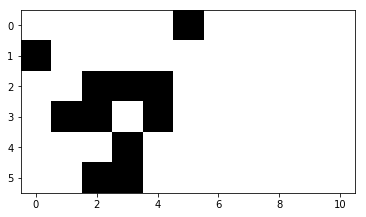

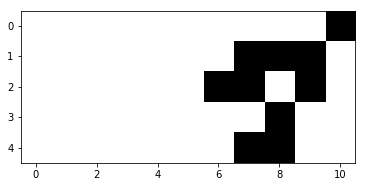

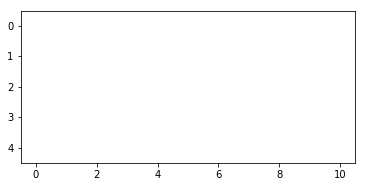

In [2]:
def repeat_copy(max_seq_len, seq_width, max_repeat=4):
    """
    Implements the repeated copy task
    max_seq_len - maximum length of the sequence
    seq_width - size of bit vector at each time step
    max_repeat - maximum number of repetitions
    """
    seq_len = 1 + np.random.randint(max_seq_len)
    repeat = 1 + np.random.randint(max_repeat)
    rand_tile = np.random.randint(2, size=(seq_len, seq_width))
    inputs = np.zeros((seq_len*(1+repeat)+3, seq_width+2))
    inputs[0,1] = 1
    inputs[seq_len+1,0] = repeat
    inputs[1:seq_len+1, 2:] = rand_tile
    targets = np.zeros((seq_len*(1+repeat)+3, seq_width+1))
    targets[-1,0] = 1
    targets[seq_len+2:-1, 1:] = np.vstack([rand_tile]*repeat)
    mask = np.ones_like(targets)
#     mask = np.zeros((seq_len*2+3, seq_width+1))
#     mask[seq_len+2:,:] = 1
    return inputs, targets, mask

inputs, targets, mask = repeat_copy(4, 4)
display(inputs.T)
display(targets.T)
display(mask.T)


Training DNC...
('Iteration', 0, 'Train loss:', 0.69069729177730632)
Test loss:  0.691287706614
Input


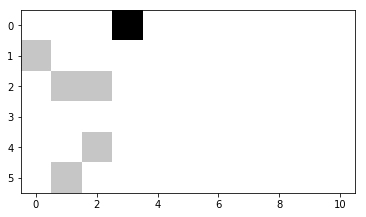

Target


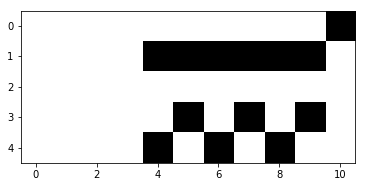

Predicted


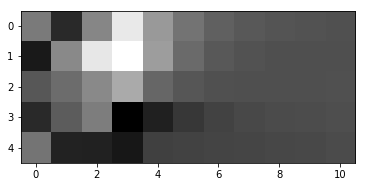

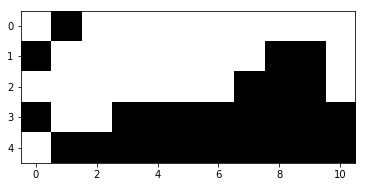

('Iteration', 1000, 'Train loss:', 0.42135382910983649)
Test loss:  0.376769325344
Input


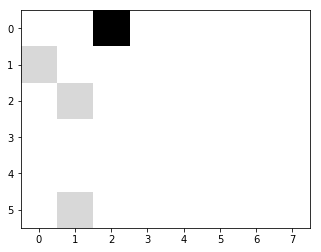

Target


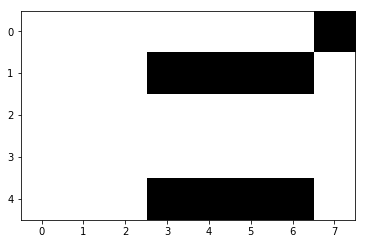

Predicted


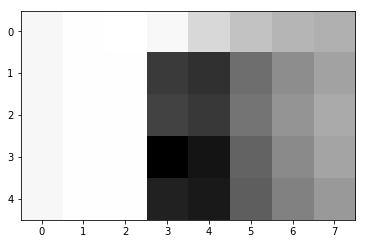

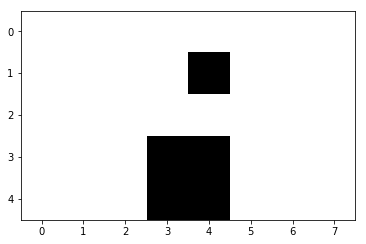

('Iteration', 2000, 'Train loss:', 0.35089708367102262)
Test loss:  0.413362477659
Input


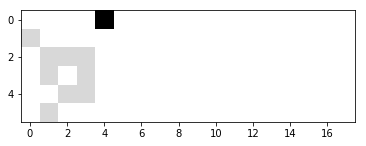

Target


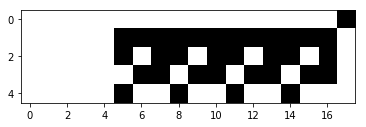

Predicted


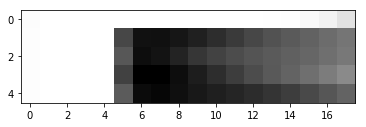

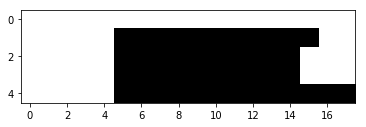

('Iteration', 3000, 'Train loss:', 0.20673547261609432)
Test loss:  0.214357775786
Input


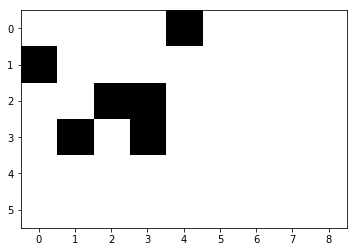

Target


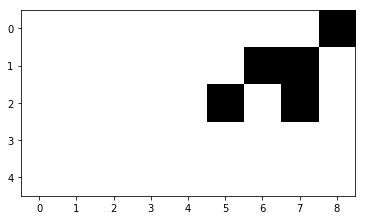

Predicted


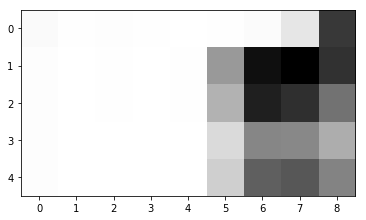

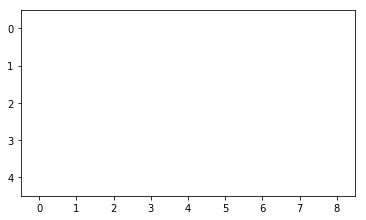

In [ ]:
## Testing recurrent DNC


def loss_fn(pred, target, mask):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return np.mean(- (a + b) * mask)

# def loss_fn(pred, target, mask):
#     pred = sigmoid(pred)
#     l2 = np.sqrt(np.square(pred - target))
#     return np.mean(l2 * mask)

def l2(x):
    """
    stable l2-norm
    """
    return np.sqrt(np.sum(np.multiply(x, x)) + 1.e-20) 

seq_len, seq_wid = 4, 4

# dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=4)
dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
dnc_params = dnc._init_params()
# for k,v in dnc_params.items():
#     print k
#     print v.shape

def print_training_prediction(params, iters):
    
    inputs, targets, mask = repeat_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    loss = loss_fn(result, targets, mask)
    print "Test loss: ", loss
#     reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
#     print "Param Mag: ", 5e-4 * reg
    print "Input"
    display(inputs.T)
    print "Target"
    display(targets.T)
    print "Predicted"
    display((sigmoid(result)).T)
    display(np.around((sigmoid(result) * mask), decimals=0).astype('int').T)
    
    # Saving Model Check Points
    save_pickle(params, './ckpt_repeat_copy/Iter_%d_Loss_%.6f.pkl' % (iters, loss))

    
def training_loss(params, iters):
    inputs, targets, mask = repeat_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
#     # regularization
#     reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
    return loss_fn(result, targets, mask) # + 5.e-4 * reg

def callback(weights, iters, gradient):
    if iters % 1000 == 0:
        print("Iteration", iters, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights, iters)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000000, callback=callback)